In [2]:
'''
Sample benchmarking iphython notebook. Combine with PTCmap module
'''

#Before using, make sure you go execute the setup.py in the helpers folder to get maptrack set up!

import sys

import matplotlib.pyplot as plt
import numpy as np

sys.path.insert(1, '../')
import helpers as hs
import os
from scipy.optimize import curve_fit
%matplotlib notebook

ImportError: ../fast_track/fast_track.so: invalid ELF header

In [2]:
#Directories

datadir = '/directory/where/simple_map/data/is/stored'
mapsdir = datadir +'/maps'
tracksdir = datadir+'/tracks'
twissdir = datadir+'/twiss'

In [3]:
#Load reference twiss/ptc_twiss files

header_twiss_ref, data_twiss_ref = hs.readtfs(twissdir+'/0_twiss_ref.tfs')
header_ptc_ref, data_ptc_ref = hs.readtfs(twissdir+'/0_ptc_twiss_ref.tfs')

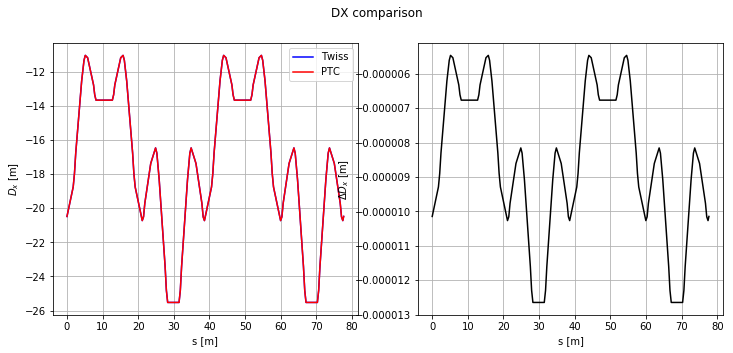

In [4]:
# Compare optics functions for Twiss and PTC

# Dispersion

f, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5))

f.suptitle('DX comparison')

ax1.plot(data_twiss_ref['S'],data_twiss_ref['DX'], 'b', label = 'Twiss')
ax1.plot(data_ptc_ref['S'],data_ptc_ref['DISP1'],'r', label = 'PTC')

ax1.set_xlabel('s [m]')
ax1.set_ylabel(r'$D_x$ [m]')
ax1.legend()
ax1.grid()

ax2.plot(data_twiss_ref['S'], data_twiss_ref['DX'] - data_ptc_ref['DISP1'], 'k',label = 'Twiss - PTC')


ax2.set_xlabel('s [m]')
ax2.set_ylabel(r'$\Delta D_x$ [m]')
ax2.grid()


<IPython.core.display.Javascript object>


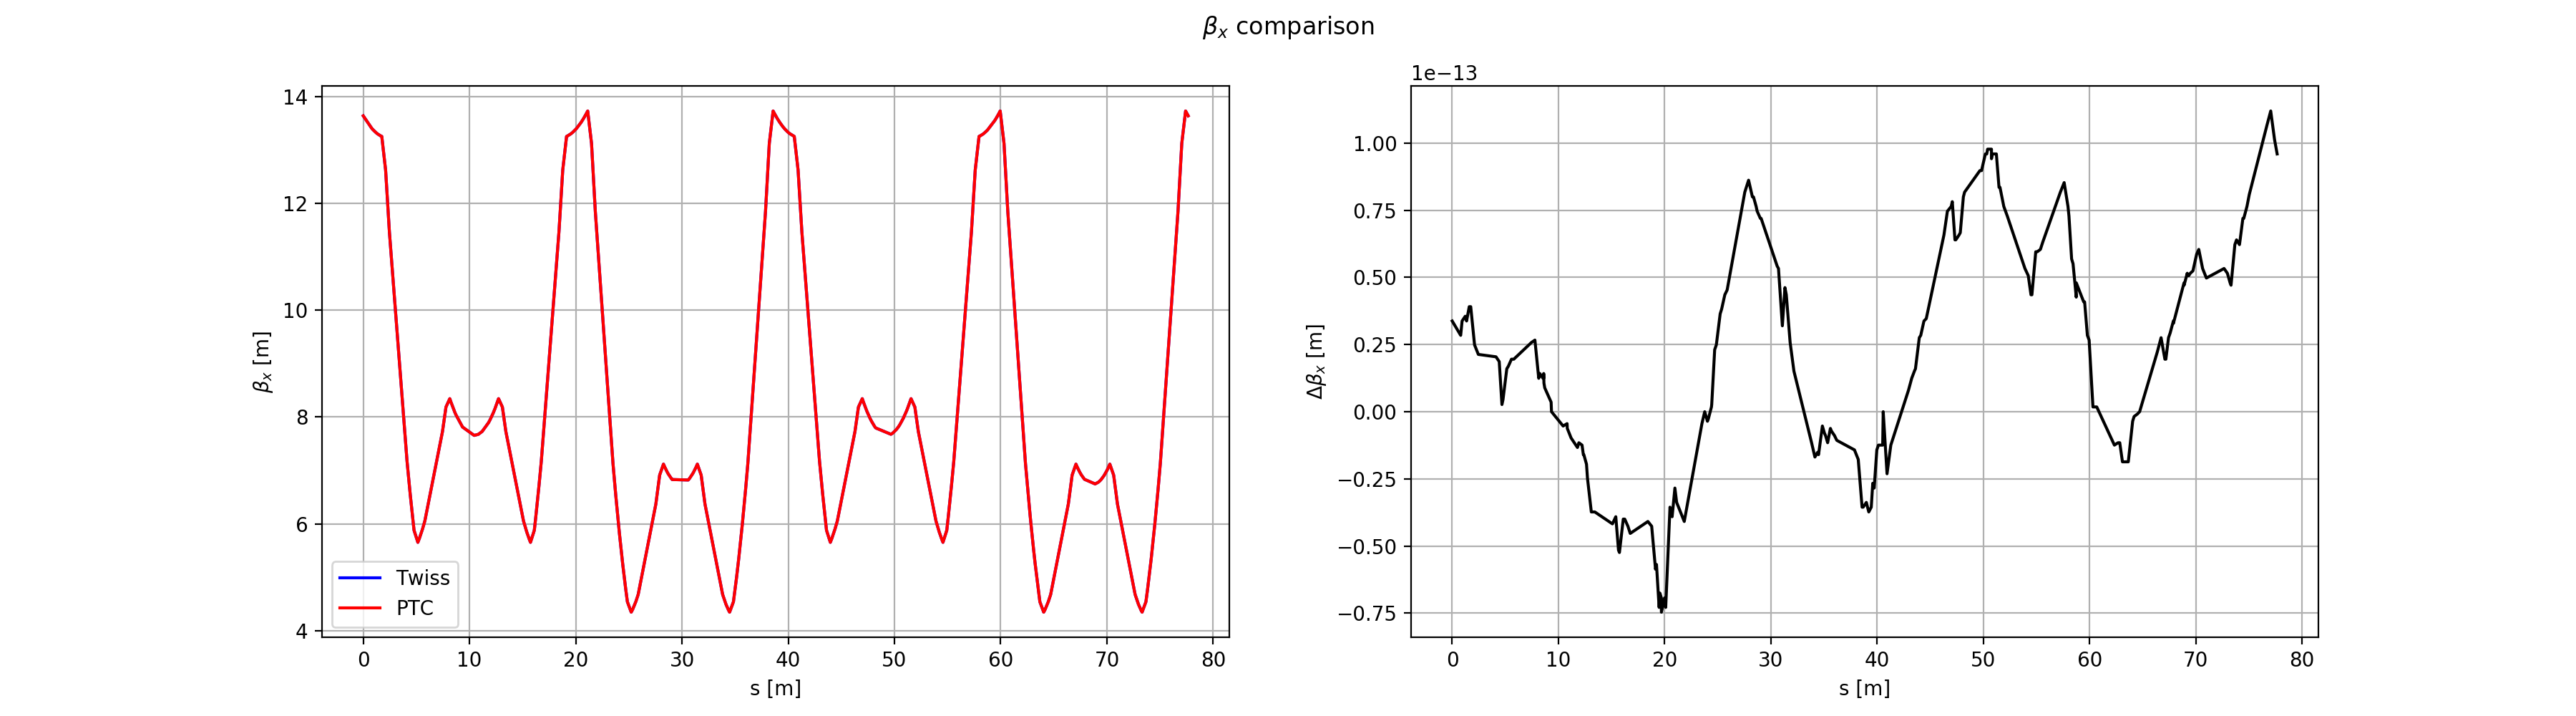

In [111]:
# Beta_x

f, (ax1,ax2) = plt.subplots(1,2,figsize=(18,5))

f.suptitle(r'$\beta_x$ comparison')

ax1.plot(data_twiss_ref['S'],data_twiss_ref['BETX'], 'b', label = 'Twiss')
ax1.plot(data_ptc_ref['S'],data_ptc_ref['BETX'],'r', label = 'PTC')

ax1.set_xlabel('s [m]')
ax1.set_ylabel(r'$\beta_x$ [m]')
ax1.legend()
ax1.grid()

ax2.plot(data_twiss_ref['S'], data_twiss_ref['BETX'] - data_ptc_ref['BETX'], 'k',label = 'Twiss - PTC')


ax2.set_xlabel('s [m]')
ax2.set_ylabel(r'$\Delta \beta_x$ [m]')
ax2.grid()

<IPython.core.display.Javascript object>


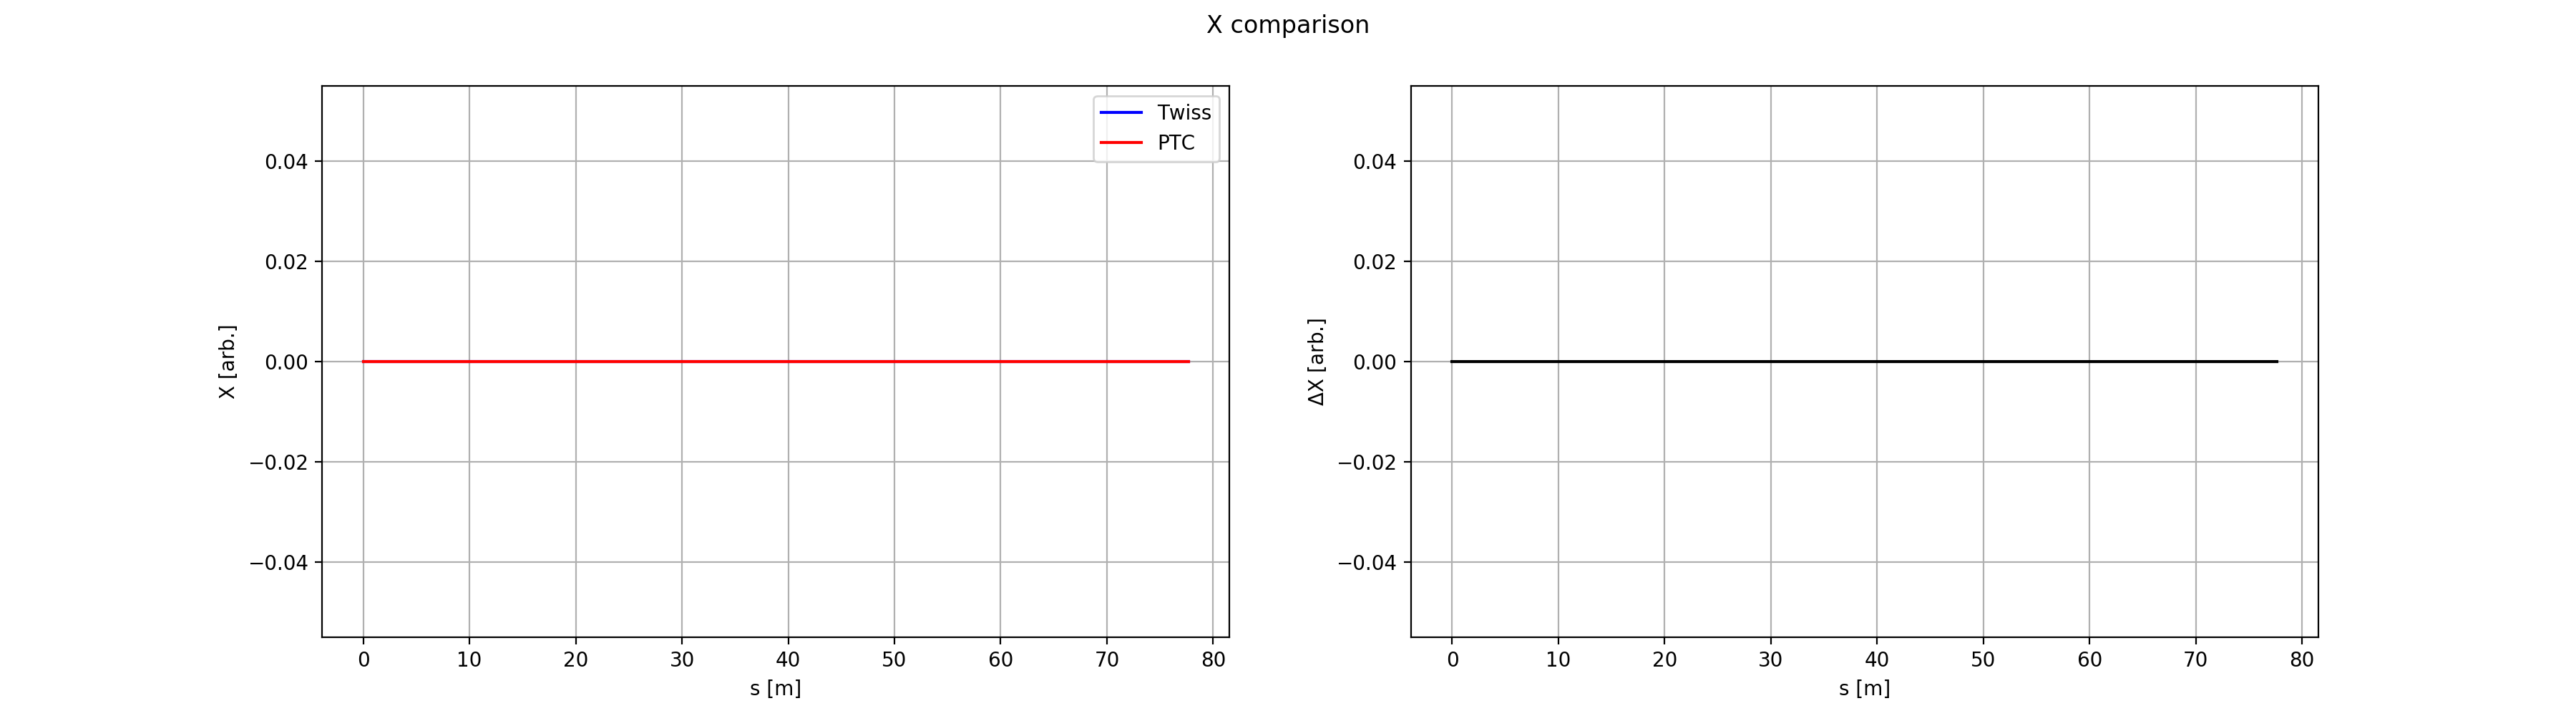

In [90]:
#Other optics (you choose)

param = 'X' #Your choice (name in twiss table)
unit = 'arb.' #Set the unit if you want to get fancy

f, (ax1,ax2) = plt.subplots(1,2,figsize=(18,5))

f.suptitle('{} comparison'.format(param))

ax1.plot(data_twiss_ref['S'],data_twiss_ref[param], 'b', label = 'Twiss')
ax1.plot(data_ptc_ref['S'],data_ptc_ref[param],'r', label = 'PTC')

ax1.set_xlabel('s [m]')
ax1.set_ylabel('{} [{}]'.format(param,unit))
ax1.legend()
ax1.grid()

ax2.plot(data_twiss_ref['S'], data_twiss_ref[param] - data_ptc_ref[param], 'k',label = 'Twiss - PTC')


ax2.set_xlabel('s [m]')
ax2.set_ylabel(r'$\Delta${} [{}]'.format(param,unit))
ax2.grid()

In [98]:
#Create python maps from PTC files
#WARNING: The program will assume the n-th file (in alphabetical order) corresponds to the n-th sector in the machine
#WARNING ctd. If you used mapping.py you should be fine.

import glob

pymaps = {}

for n,filename in enumerate(sorted(glob.glob(os.path.join(mapsdir, '*_ptc_map_*.tfs')))):
    pymaps[str(n)] = hs.getPTCmap(filename) 

In [99]:
import pandas as pd

track_df = pd.DataFrame()

for n,filename in enumerate(sorted(glob.glob(os.path.join(tracksdir, 'trackout*')))): #input all tracks
    header_part, track_part = hs.readtfs(filename)
    track_df = pd.concat([track_df,track_part]) #Make a df with all data

In [100]:
track_df.head(n=2) #Here's how it looks

TURN    X   PX    Y   PY             T   PT    S         E
NUMBER                                                            
1          0  0.0  0.0  0.0  0.0 -0.000000e+00  0.0  0.0  0.971007
1          1  0.0  0.0  0.0  0.0 -1.776357e-15  0.0  0.0  0.971007

In [101]:
#Grab the number of turns and number of particles to initialize numpy array
nturns = int(data['TURN'].max())
npar = int(data.index.max())
ndim=6 #Dimensions of phase space

particles_ptc = np.zeros((ndim,npar,nturns+1))

#Some awkward data transformation, as promised
for number, row in data.iterrows():
     particles_ptc[:,int(number)-1,int(row['TURN'])] = np.array([row['X'],row['PX'],
                                                                   row['Y'],row['PY'],
                                                                   row['T'],row['PT']])

In [102]:
#Grab the initial conditions and apply maptrack function
particles0 = particles_ptc[:,:,0]

particles_map,_ = hs.trackPTC(particles0, nturns, 68, 44, [pymaps[key][0] for key in sorted(pymaps)],
                                         [pymaps[key][1] for key in sorted(pymaps)], turnByTurn=True)

In [103]:
x_map = particles_map[0,:,:]
px_map = particles_map[1,:,:]
x_ptc = particles_ptc[0,:,:]
px_ptc = particles_ptc[1,:,:]

obs_ele = data_twiss_ref.index[0] 
#I grab the first element of my sequence, since it is my observation point.
#I will use the optics at this element to normalize
#If you used mapping.py it should be the same for you

xn_map,pxn_map = hs.get_norm_x(x_map,px_map,data_ptc_ref['ALFX'][obs_ele],data_ptc_ref['BETX'][obs_ele])
xn_ptc,pxn_ptc = hs.get_norm_x(x_ptc,px_ptc,data_ptc_ref['ALFX'][obs_ele],data_ptc_ref['BETX'][obs_ele])

jx_map, phix_map = hs.get_jx_phix(xn_map,pxn_map)
jx_ptc, phix_ptc = hs.get_jx_phix(xn_ptc,pxn_ptc)

<IPython.core.display.Javascript object>


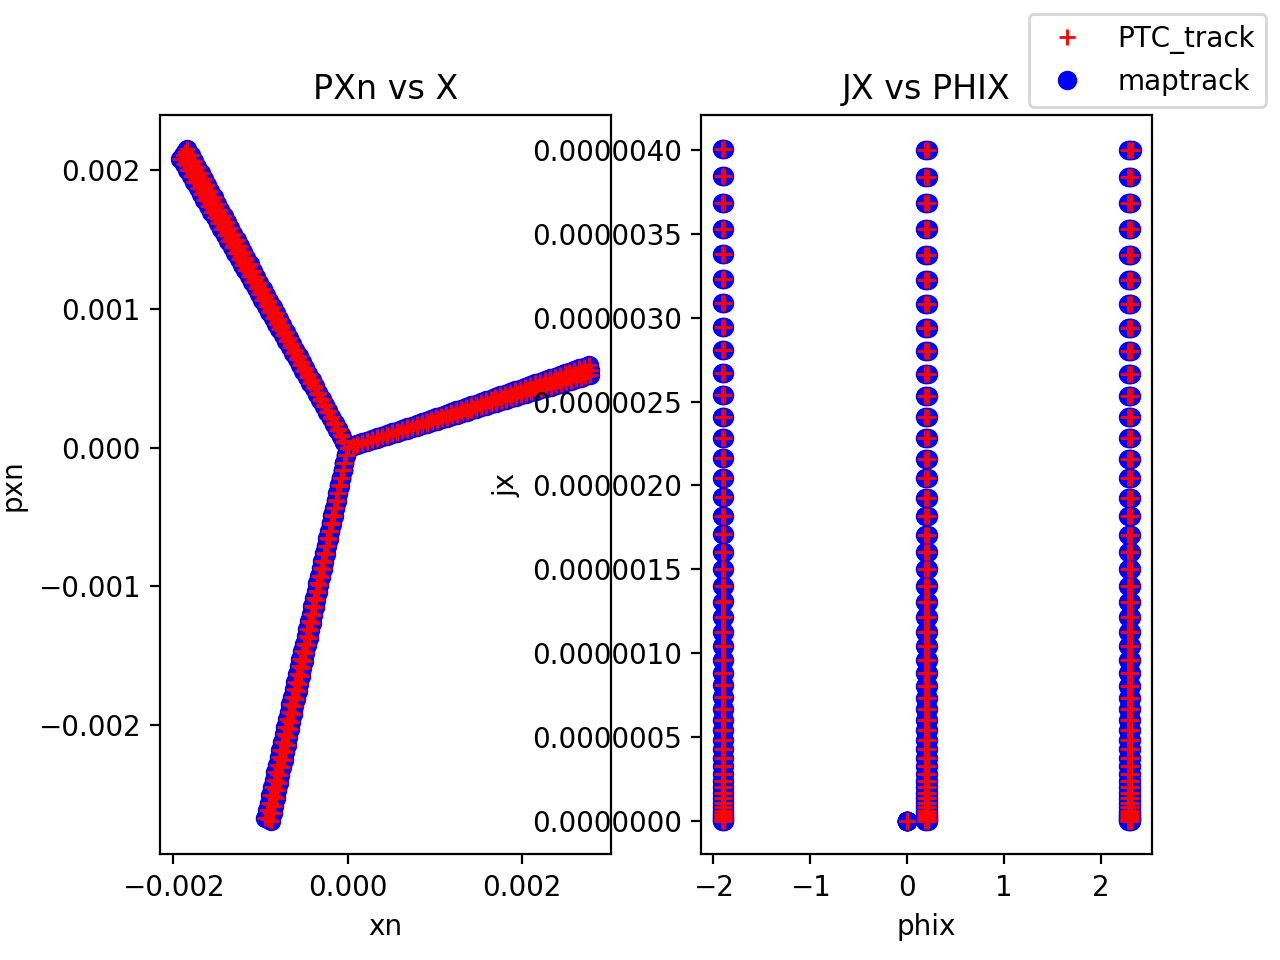

In [106]:
#Plot the calculated quantities

f, (ax1,ax2) = plt.subplots(1,2)

ax1.plot(xn_map,pxn_map,'bo',label='maptrack')
ax1.plot(xn_ptc,pxn_ptc,'r+',label='PTC_track')
ax1.set_title('PXn vs X')
ax1.set_xlabel('xn')
ax1.set_ylabel('pxn')

ax2.plot(phix_map,jx_map,'bo')
ax2.plot(phix_ptc,jx_ptc,'r+')
ax2.set_title('JX vs PHIX')
ax2.set_xlabel('phix')
ax2.set_ylabel('jx')

handles, labels = ax1.get_legend_handles_labels() #Hack to avoid duplicate labels
by_label = dict(zip(labels, handles))
f.legend(by_label.values(), by_label.keys())

In [105]:
#Now let's compute the differences in action-angle

jx_rms = np.sqrt(np.mean((jx_map-jx_ptc)**2))
phix_rms = np.sqrt(np.mean((phix_map-phix_ptc)**2))

print('The RMS difference in JX is {}'.format(jx_rms))
print('The RMS difference in PHIX is {}'.format(phix_rms))

The RMS difference in JX is 1.32741212733e-13
The RMS difference in PHIX is 3.59146479385e-08
